# **6장 – 결정 트리**

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 훈련과 시각화
### 훈련

In [ ]:
# 결정트리 (DecisionTreeClassifier) => 화이트박스 형태로, 모델의 결과가 사각형의 형태로 나뉘어 이해하기 쉬운 형태로 나온다. -> 설명이 잘되있음
# 한가지 특징을 이용해 2개의 노드로 분리하는 과정을 반복하여, 불순도와 MSE를 줄이는 방향으로 만들어야 한다. 
# gini:불순도(분류,범주형)  <-->  MSE:오차(회귀,연속형)
# 불순도 = 노드의 샘플 클래스가 얼마나 분산되어 있는지를 측정하는 것 -> 최상=0, 최하=0.5
# 따라서 불순도를 보면 특징으로 인해 샘플들이 얼마나 잘 분류(분포)되어있는지를 알 수 있다.

# 다른 모델들은 거의다 최적의 파라미터를 구하는 것이 목표이다. -> 결정트리는 비모수모델로, 수학적 분포함수에 의존하지 않는다.
# 비모수모델은 데이터 분포에 제한이 없어 복잡도가 크다.

# CART 알고리즘 사용 --> 분할시 최대 2개의 노드로밖에 분할하지 못한다.  <-> ID3 : 다중분류 가능하지만, 범주형 데이터만 가능(별로 안좋음)
# 분류,회귀 모두 사용가능하며, 복잡한 데이터셋도 학습할 수 있다.

# 과대적합(test셋에서는 성능이 좋지않음)이라 복잡도를 줄여줘야 한다. -> 규제를 사용해야 한다.(규제종류는 교재보기)
# 계속해서 자식노드로 갈수록 불순도를 줄여가는게 목표이다. -> ex)규제를 통해 불순도 0되면 멈추게해야함

# 장점 : 규칙을 표현하는데 가장 적합한 모델이다. 굉장이 빠르다.
# 단점 : 훈련세트의 변화에 많이 민감하다. 회전에대해 민감하다.
# 단점은 어려개의 결정트리를 만들어서 감소시킬수 있다.

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)#depth를 2줘서 총 2번 분할하도록함
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### decision tree 시각화

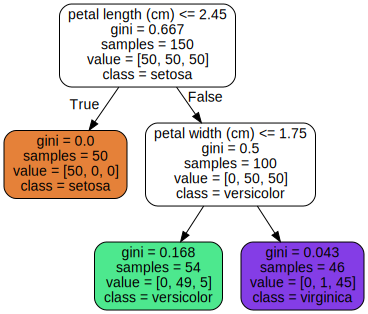

In [ ]:
# 훈련된 decision tree를 시각화
# 특징을 이용해 2진분류로 계속 내려가면서 불순도를 줄여간다. 
# 전체 샘플은 150개, value[50(setosa), 50(versicolor), 50(virginica)]
# value = [0, 49, 5] , class = versicolor 의미 => 
# 꽃잎길이가 2.45보다 크고, 꽃잎너비가 1.75보다 작은 데이터가 versicolor가 49개, virginica가 5개 있다.
# 따라서 꽃잎길이가 2.45보다 크고, 꽃잎너비가 1.75보다 작은 데이터 중, 49/50의 확률로 versicolor 이고, 5/50 확률로 virginicad이다.

from graphviz import Source
from sklearn.tree import export_graphviz# 결정함수 그리는 함수

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

**식 6-1: 지니 불순도 (default) **

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$

**식 6-3: 엔트로피 불순도 (criterion='entropy') **

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$


**식 6-2: 분류에 대한 CART 비용 함수**

$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{여기에서 }\begin{cases}
G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도}\\
m_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
\end{split}
$

### decision boundary 시각화

그림 저장: decision_tree_decision_boundaries_plot


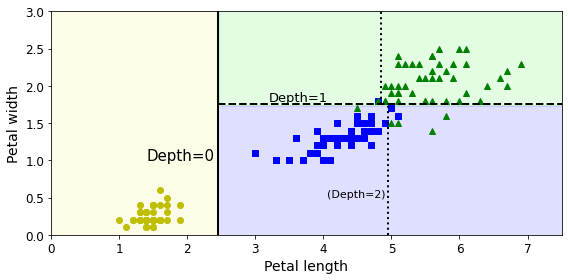

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)

plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()


# 클래스와 클래스 확률을 예측하기

In [ ]:
# (5, 1.5) 좌표의 데이터가 어디에 속하는지 알 수 있음 ->Depth=2의 왼쪽에 속하는것을 알 수 있다.(샘플갯수=54)
# 0=setosa,  0.9 = versicolor  0.09=virsinica
# 따라서 0.9 의 높은 확률로 versicolor라는것을 알 수 있다.

tree_clf.predict_proba([[5, 1.5]])  # 클래스 확률 : leaf node에서 샘플의 비율 (0/54, 49/54, 5/54)

array([[0.        , 0.90740741, 0.09259259]])

In [ ]:
tree_clf.predict([[5, 1.5]])  # 클래스 예측

array([1])

# 훈련 세트에 민감함

In [ ]:
# 이상값을 버리면 결정트리가 어떻게 달라지는지 보기 위해서
# 이상값 1개[4.8 , 1.8]를 제거해봄

# 클래스 1 (versicolor) 중에서 꽃잎너비가 가장 넓은 샘플 선택
a = (X[:, 1]==X[:, 1][y==1].max()) & (y==1) # widest Iris versicolor flower
ind = np.where(a)[0]  # a==True인 샘플들의 인덱스
print('widest versicolor index, feature_value : ', ind, X[ind])

widest versicolor index, feature_value :  [70] [[4.8 1.8]]


In [ ]:
# 샘플이 하나 제거된것을 알 수 있다.

# X_tweaked : X 에서 꽃잎너비가 가장 넓은 샘플만 제외해한 것
X_tweaked = X[a == False] # widest Iris versicolor flower 만 제외
y_tweaked = y[a == False]
print('X, X_tweaked :', X.shape, X_tweaked.shape)

X, X_tweaked : (150, 2) (149, 2)


In [ ]:
# X_tweaked 학습
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=40, splitter='best')

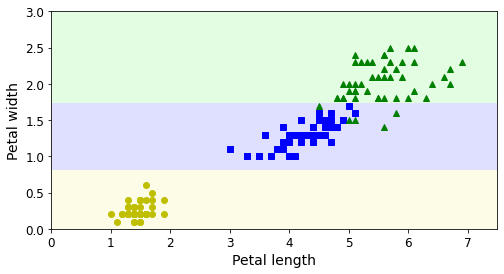

In [ ]:
# 샘플 하나만 제거했음에도 그래프가 엄청 달라진것을 알 수 있다 => 결정트리 모델은 데이터셋에 굉장히 민감하게 반응한다.

# 학습한 decision boundary 시각화
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
#plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
#plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
#plt.text(1.0, 0.9, "Depth=0", fontsize=15)
#plt.text(1.0, 1.80, "Depth=1", fontsize=13)

#save_fig("decision_tree_instability_plot")
#plt.show()

# 규제 : 자유도 제한

그림 저장: min_samples_leaf_plot


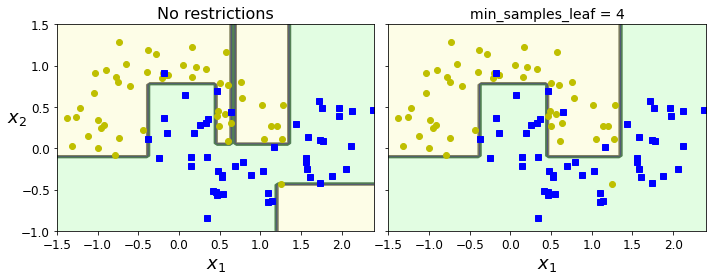

In [ ]:
# 규제 종륲가 많은데, 그중에서 min_samples_leaf 로 다음 노드의 샘플 갯수가 4가 아니면 중단하라고 함
# min_samples_leaf 설정해서 규제하는 예 : make_moons 데이터
# 왼쪽그래프는 train데이터에서는 성능이 좋을것이다.
# 오른쪽 그래프는 train데이터에서 성능은 좀 떨어지지만 test데이터에서는 성능이 좋을 것이다. 

from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

Text(0.5, 1.0, 'Xr')

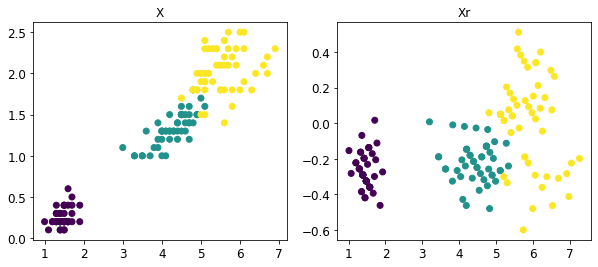

In [ ]:
# 데이터를 회전시켜 더 간단한 결정 트리를 얻는 예
# 데이터를 잘 회전시키면 더 부드러운 결정트리그래프를 얻을 수 있다.
# 그러나 회전을 너무 많이 시키면 결정그래프가 더 안좋아진다.

angle = np.pi / 180 * 20  # 20도 만큼 시계방향으로 회전할 것임
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])# 회전시키는 함수
Xr = X.dot(rotation_matrix)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
plt.sca(axes[0])
plt.scatter(X[:,0], X[:,1], c=y)
plt.title('X')

plt.sca(axes[1])
plt.scatter(Xr[:,0], Xr[:,1], c=y)
plt.title('Xr')

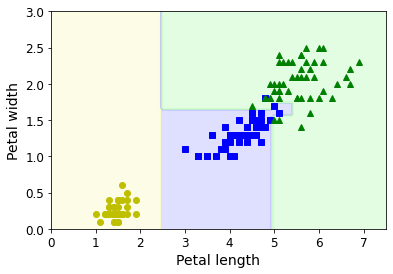

In [ ]:
# 원 데이터 (X) 학습한 결과 decision boundary
# 결정함수는 이상치 하나때문에 그래프가 많이 달라진다.
# 휸련세트의 작은 변화에도 민감하게 반응한다.

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X, y)

plot_decision_boundary(tree_clf, X, y)

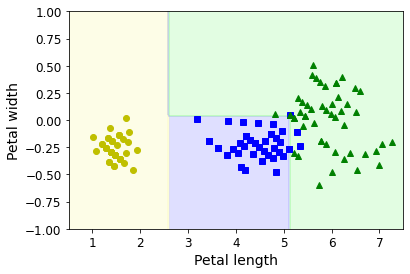

In [ ]:
# 회전환 데이터 (Xr) 학습한 결과 decision boundary

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

#plt.figure(figsize=(8, 3))
#plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1])

#plt.show()

그림 저장: sensitivity_to_rotation_plot


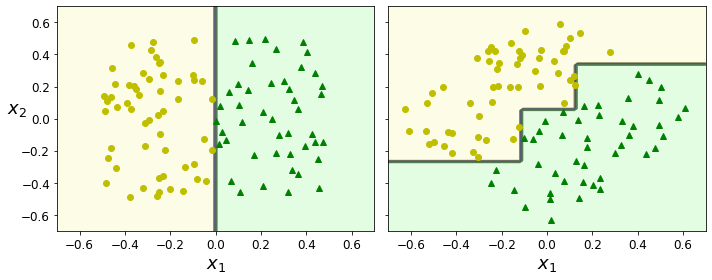

In [ ]:
# 각도를 더 많이 회전시켜서 결정트리 구했을 경우 -> 결과가 안좋아짐
# 결정함수는 svc와 다르게 분류가 각진 형태로 되기때문에 데이터를 회전시키는 경우에 취약하다
# 두번째 그래프에 대각선으로 직선을 그었으면 오류가 없었을 탠데, 
# 결정함수로 하면 노드가 내려갈수록 2진으로 분류하기 때문에 각진형태의 그래프가 만들어진다. 
# 따라서 PCA함수를 통한다음에 결정함수를 사용하는 것이 좋다.

# 잘 못 회전해서 안 좋아진 예

np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4    # 45도 회전
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

# 회귀 트리

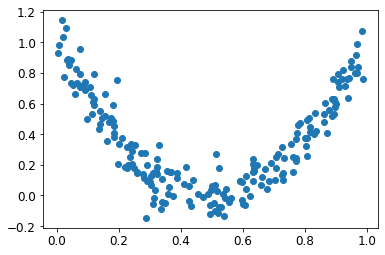

In [ ]:
# 회귀시작 -> 앞에꺼는 다 "분류"한것임
# 회귀는 연속된 값, 분류는 이진분류 또는 다항분류,
# 회귀는 "평균과 실제값의 오차"(MSE)를 줄이는것을 목표로 한다. -> 분류는 불순도 줄이는걸 목표로 함


# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

plt.scatter(X, y)

Text(0.5, 1.0, 'max_depth=2')

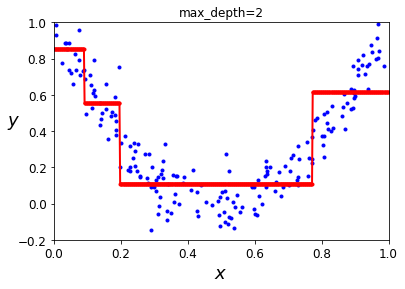

In [ ]:
# 편편한곳이 평균임
# 평균과의 차이 = (오차) 를 줄이는것이 목표이다. 

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

############ 시각화
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")#실제값 =파란색 "." 으로 그렸다
    plt.plot(x1, y_pred, "r.-", linewidth=2)# 예측값 = 빨간색 "."과 "-" 로 그렸다

plot_regression_predictions(tree_reg, X, y)
plt.title('max_depth=2')

Text(0.5, 1.0, 'max_depth=3')

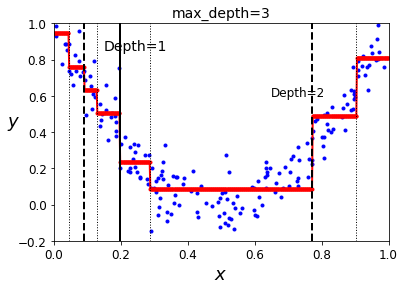

In [ ]:
# Depth기준으로 나눌 수 있다.
# Depth가 작아지면서 오차가 줄어드는것을 볼 수 있다.

# max_depth=3 경우
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg2.fit(X, y)

plot_regression_predictions(tree_reg2, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.15, 0.85, "Depth=1", fontsize=14)
plt.text(0.65, 0.6, "Depth=2", fontsize=12)
plt.title("max_depth=3", fontsize=14)


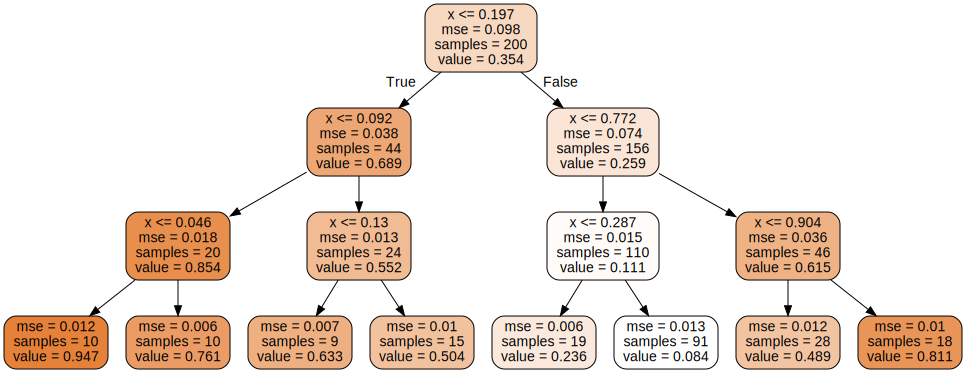

In [ ]:
# max_depth = 3 경우 decision tree

export_graphviz(
        tree_reg2,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x"],
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

그림 저장: tree_regression_regularization_plot


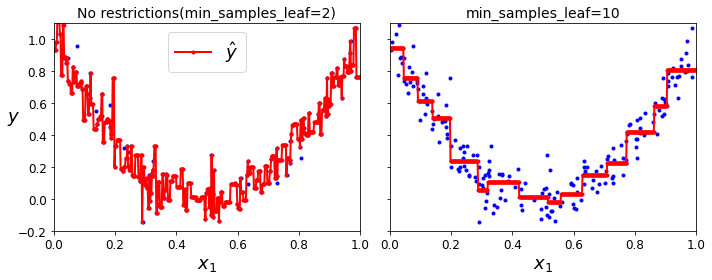

In [ ]:
# 결정트리는 복잡도가 높아 규제를 해줘야 한다.
# 첫번째는 규제를 하지 않은 그래프고, 두번째 그래프는 자식노드의 셈플수가 최소 10개는 되야한다는 규제를 한것이다. 

# min_samples_leaf = 2와 10 비교

tree_reg1 = DecisionTreeRegressor(random_state=42) # default min_samples_leaf = 2 -> 너무 복잡한 그래프가 나옴
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)# 규제를 더 많이 줬음 -> 다음 노드의 샘플이 10개여야 함 -> 자식노드를 더 안만듬
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions(min_samples_leaf=2)", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# <font color=red> 과제 </font>
다음 fashion MNIST 데이터에 대해 decision tree classifier를 이용하여 분류한 결과를 보여라. <p>
1) 학습데이터를 1000개를 선택해서 학습한 후 학습데이터 분류 정확도와 시험데이터 분류 정확도를 보여라.  단 학습할 때 max_leaf_nodes를 10, 100, 1000 으로 바꿔서 실험 결과 (정확도)를 보이기 바란다.  학습 데이터정확도와 시험데이터 정확도의 차이도 적기 바란다. <p>
2) 위 실험에서 학습 데이터를 전체(60000개)를 사용해서 max_leaf_nodes=100으로 한 경우 학습데이터와 시험데이터에 대해 각각의 정확도를 보여라. 학습 데이터정확도와 시험데이터 정확도의 차이도 적기 바란다. <p>
3) 이 실험에서 알아낸 사실들을 적어라.


In [4]:
# 학습데이터와 test데이터를 분류하고,  학습시킨 결정트리 모델로 두개다 예측해봐라 -> 
# 결정트리는 복잡도가 높기 때문에 과대적합이 일어날 가능성이 많다. -> 학습데이터에서는 결과가 잘 나오겠지만, test에서는 안나올 가능성이 있다.


from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, type(X_train), y_train.shape, type(y_train)

X_train = X_train.reshape(-1, 784)  
X_test = X_test.reshape(-1, 784)

print('X_train, y_train :', X_train.shape, y_train.shape)
print('X_test, y_test :', X_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
X_train, y_train : (60000, 784) (60000,)
X_test, y_test : (10000, 784) (10000,)


해답

In [2]:
 from sklearn.tree import DecisionTreeRegressor

In [5]:

x_train_1000 = X_train[:1000]
y_train_1000 = y_train[:1000]
x_test_1000 = X_test[:1000]
y_test_1000 = y_test[:1000]

print(x_train_1000.shape)
print(y_train_1000.shape)

(1000, 784)
(1000,)


In [6]:
# 해답 
# 자식노드가 없는 노드 = leaf_node
train_accuracy = 0
test_accuracy = 0

def main(n,sample_cnt):
  if (sample_cnt == 1000):
    learning_1000(n,sample_cnt)
  
  else:
    learning_60000(n,sample_cnt)


def learning_1000(n,sample_cnt):
  tree_reg = DecisionTreeRegressor(random_state=42,max_leaf_nodes=n)
  tree_reg.fit(x_train_1000, y_train_1000)
  train_accuracy = 0
  test_accuracy = 0
  train_accuracy = tree_reg.score(x_train_1000,y_train_1000)
  test_accuracy = tree_reg.score(x_test_1000,y_test_1000)
  a = (train_accuracy-test_accuracy)#정확도 차이
  print("max_leaf_nodes=",n,", 학습샘플수=",sample_cnt,", 학습데이터정확도=",train_accuracy,", 시험데이터정확도=",test_accuracy,". 차이=",a)

def learning_60000(n,sample_cnt):
  tree_reg = DecisionTreeRegressor(random_state=42,max_leaf_nodes=n)
  tree_reg.fit(X_train, y_train)
  train_accuracy = 0
  test_accuracy = 0
  train_accuracy = tree_reg.score(X_train,y_train)
  test_accuracy = tree_reg.score(X_test,y_test)
  a = (train_accuracy-test_accuracy)#정확도 차이
  print("max_leaf_nodes=",n,", 학습샘플수=",sample_cnt,", 학습데이터정확도=",train_accuracy,", 시험데이터정확도=",test_accuracy,". 차이=",a)



main(10,1000)
main(100,1000)
main(1000,1000)
main(100,60000)




max_leaf_nodes= 10 , 학습샘플수= 1000 , 학습데이터정확도= 0.7848451625865887 , 시험데이터정확도= 0.6874649498014843 . 차이= 0.09738021278510434
max_leaf_nodes= 100 , 학습샘플수= 1000 , 학습데이터정확도= 0.9930648639442261 , 시험데이터정확도= 0.6116655813174816 . 차이= 0.3813992826267445
max_leaf_nodes= 1000 , 학습샘플수= 1000 , 학습데이터정확도= 1.0 , 시험데이터정확도= 0.600469686436881 . 차이= 0.39953031356311897
max_leaf_nodes= 100 , 학습샘플수= 60000 , 학습데이터정확도= 0.8172035142910637 , 시험데이터정확도= 0.7832733736212847 . 차이= 0.03393014066977906


### 실험 결과 분석 결과 예
여기에 실험 결과를 분석한 내용을 적기 바람 <p>
1) 학습데이터 정확도는 max_leaf_node값이 커짐에 좋아진다. 과대적합이되기 때문에 <p>
2) leaf_node는 자식이 없는 노드를 뜻한다. 자식이 없는 노드는 오차가 0이다,  <p>
3) max_leaf_node값이 학습샘플수와 같아지면 학습데이터정확도는 1로 완전히 맞추게 된다. <p>
3) 규제가 줄어들면 -> 복잡도 증가 -> 과대적합됨 <p>
4) max_leaf_node값이 커지면 (규제가 적어져서 ) 학습데이터와 시험데이터의 정확도 차이가 늘어난다.<p>
5) 시험데이터의 정확도를 올리기 위해서는 복잡도를 줄여야 한다. -> 일반화 해야한다.<p>
6) 일반화를 하기 위해서는 샘플의 갯수를 늘리거나, C의 값을 줄여줘야 한다.(규제를 많이해야한다.) <p>

